Importing Libraries

In [21]:
import os
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


Setting up CPU cores and suppressing warnings

In [22]:
os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # Replace "4" with the desired number of CPU cores
warnings.filterwarnings("ignore", category=UserWarning, module="joblib")

Loading Datasets

In [23]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

Merging Datasets

In [24]:
merged_data = transactions.merge(customers, on="CustomerID")

Feature Engineering

In [25]:
customer_profiles = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Number of transactions
    'Quantity': 'sum',  # Total quantity purchased
}).rename(columns={'TransactionID': 'TransactionCount'})

# Add demographic information from Customers.csv
customer_profiles = customer_profiles.merge(customers[['CustomerID', 'Region']], on='CustomerID')

# One-hot encode the 'Region' column
customer_profiles = pd.get_dummies(customer_profiles, columns=['Region'], prefix='Region')

# Drop the CustomerID column (not needed for clustering)
customer_ids = customer_profiles.pop('CustomerID')


Data Scaling

In [26]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_profiles)

Clustering and Evaluation

In [27]:
db_scores = []
cluster_range = range(2, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    db_scores.append(db_index)

# Find the optimal number of clusters
optimal_clusters = cluster_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")


Optimal number of clusters: 10


Final Clustering

In [28]:
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
final_labels = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original data
customer_profiles['Cluster'] = final_labels


Visualization

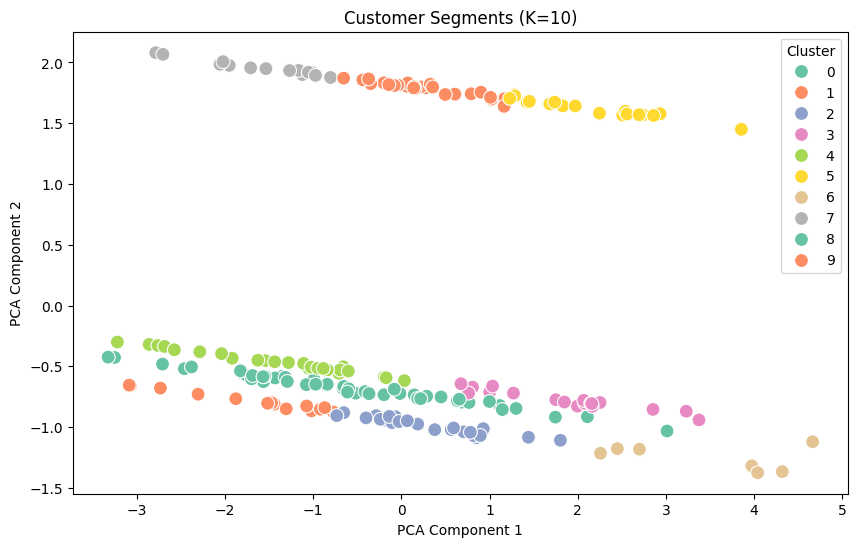

In [29]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = final_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=100)
plt.title(f"Customer Segments (K={optimal_clusters})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()


Saving the Results

In [30]:
customer_profiles.to_csv("Kuldeep_Clustering.csv", index=False)